In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34339,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.04 GiB
Comm: tcp://127.0.0.1:36497,Total threads: 4
Dashboard: http://127.0.0.1:42783/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:45153,


# Merge

In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 55.6 ms, sys: 3.95 ms, total: 59.6 ms
Wall time: 56.3 ms


In [5]:
%%time

index=0
before = get_ddf_shape(bbdd_completa)
print(before)

index+=1
print(index)
# 1 Error fix. # 2019 gener, febrer and marc have the status reversed
cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))
index+=1
print(index)
# 2 Remove not needed status, manitenance, planned. open = 0, closed = 1 
cond = (bbdd_completa['status'].isin([2.0,3.0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, 1.0)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])
index+=1
print(index)
# 3 Remove data from 2020
cond = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])
index+=1
print(index)
# 4 2019 to 2020 to have continuos data 
cond = (bbdd_completa['year'].isin([2019]))
bbdd_completa['year'] = bbdd_completa['year'].mask(cond, bbdd_completa['year']+1)
index+=1
print(index)
# 5 status reversed 
bbdd_completa['status'] = (bbdd_completa['status'] + 1)%2
index+=1
print(index)
# 6 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_installed'])
index+=1
print(index)
# 7 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])
index+=1
print(index)
# 8 Remove row where status = closed and is renting and is returning
# cond = (bbdd_completa['status'].isin([0.0])) & (bbdd_completa['is_renting'].isin([1.0])) & (bbdd_completa['is_returning'].isin([1.0]))
# bbdd_completa = bbdd_completa.mask(cond, np.nan)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(12419994, 23)
1
2
3
4
5
6
7
8
(12419489, 21)
Changes to dataframe durinf preprocessing
dropeed -505 rows
dropped -2 columns
CPU times: user 3.39 s, sys: 155 ms, total: 3.54 s
Wall time: 14.3 s


In [6]:
%%time

unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2020])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

year
2020.0    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
Name: station_id, dtype: object
2020.0 (410,)
2021.0 (509,)
2022.0 (510,)
408
CPU times: user 1.23 s, sys: 125 ms, total: 1.35 s
Wall time: 7.61 s


In [7]:
%%time

before = get_ddf_shape(filtered_bbdd)
print(before)

filtered_bbdd = filtered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(filtered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(10627655, 21)


2023-06-04 20:40:52,902 - distributed.worker.memory - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 5.40 GiB -- Worker memory limit: 6.21 GiB
2023-06-04 20:40:53,080 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 3.59 GiB -- Worker memory limit: 6.21 GiB


(10526888, 21)
Changes to dataframe durinf preprocessing
dropeed -100767 rows
dropped 00 columns
CPU times: user 6.05 s, sys: 536 ms, total: 6.58 s
Wall time: 24 s


In [8]:
%%time

before = get_ddf_shape(nonfiltered_bbdd)
print(before)

nonfiltered_bbdd = nonfiltered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(nonfiltered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(1791834, 21)
(1771494, 21)
Changes to dataframe durinf preprocessing
dropeed -20340 rows
dropped 00 columns
CPU times: user 5.48 s, sys: 473 ms, total: 5.95 s
Wall time: 20.6 s


# Predicción__________________________________
a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [9]:
import os
import csv
import pandas as pd
import random
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

DATA_DIR = 'dades'
OUTPUT_DIR = './'

In [11]:
class Config:
    num_attribs0 = ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = ['month', 'dayofweek', 'day', 'hour'] # dayofyear
    cat_attribs1 = ['station_id']
    gen_attribs0 = [] # ['status']
    target_col = ['ctx0']

    epochs=5
    batch_size=128
    seed=42
    embedding_dim=8
    lr=1e-4

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [12]:
config=Config()
seed_everything(config.seed)

In [13]:
filtered_bbdd.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_renting', 'is_returning',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [14]:

def build_preprocessor(config): 
    num_attribs0 = config.num_attribs0 # ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = config.cat_attribs0 #['month', 'dayofweek', 'day', 'dayofyear', 'hour' ]
    cat_attribs1 = config.cat_attribs1 #['station_id']
#     gen_attribs0 = config.gen_attribs0 #['status']
    
    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder())),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
#     generic_transformer0 = Pipeline([
#         ("imputer", SimpleImputer(strategy="mean")),
#     ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
#             ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

def apply_pipeline(config, x_train,x_test,y_train,y_test, show=True):
    
    full_pipeline = build_preprocessor(config)

    x_train_prepared = full_pipeline.fit_transform(x_train)
    x_test_prepared = full_pipeline.transform(x_test)
    
    if show:
        print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
        print("x_test_prepared:",x_test_prepared.shape,"y_test: ",y_test.shape)

    return x_train_prepared,x_test_prepared,y_train,y_test


In [15]:
train_data2020 = filtered_bbdd[filtered_bbdd.year.isin([2022])]
get_ddf_shape(train_data2020)

(3541851, 21)

In [16]:
test_data2020 = nonfiltered_bbdd[nonfiltered_bbdd.year.isin([2022])]
get_ddf_shape(test_data2020)

(882910, 21)

In [17]:
%%time 

x_train, x_test, y_train, y_test = train_data2020.compute().copy(),test_data2020.compute().copy(), train_data2020.ctx0.compute().copy(), test_data2020.ctx0.compute().copy()


CPU times: user 7.4 s, sys: 1.61 s, total: 9.01 s
Wall time: 47.9 s


In [18]:
%%time 

x_train_prepared,x_test_prepared,y_train,y_test = apply_pipeline(config, x_train,x_test,y_train,y_test)

x_train_prepared: (3541851, 417) y_train:  (3541851,)
x_test_prepared: (882910, 417) y_test:  (882910,)
CPU times: user 3.01 s, sys: 421 ms, total: 3.43 s
Wall time: 3.09 s


In [19]:
%%time 

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,x_train_prepared, y_train,'Linear Regression')
#  Linear Regression
# Scores: [0.86876116 0.85690033 0.83716171 0.82008556 0.8135665 ]
# Mean: 0.8392950517172396
# Standard deviation: 0.021041440859117303


  Linear Regression
Scores: [0.81364582 0.81717717 0.81316458 0.81492124 0.81631799]
Mean: 0.8150453587706241
Standard deviation: 0.0015281128416396233
CPU times: user 50.7 s, sys: 2min 24s, total: 3min 15s
Wall time: 15.2 s



Training time: 0.061 s
----- EVALUATION ON VAL SET ------
MSE: 0.012619347920367263
RMSE 0.11233587103132847
MAE: 0.07493170810584807
R^2:  0.8151067231168971



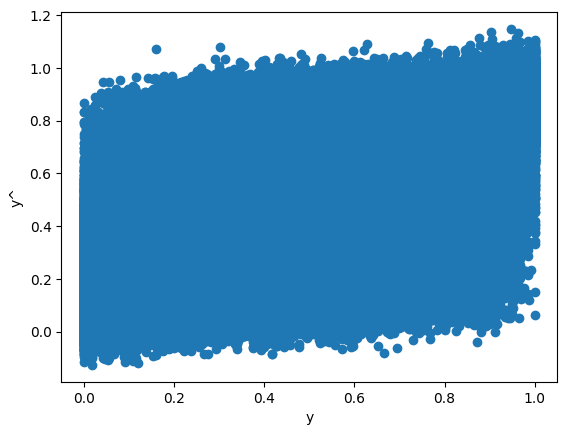


Testing time: 0.011 s
----- EVALUATION ON VAL SET ------
MSE: 0.009226668278492455
RMSE 0.09605554787982033
MAE: 0.06501703857053986
R^2:  0.858014169915365



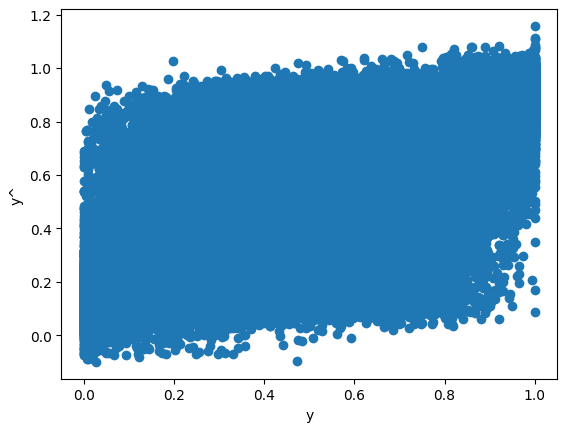

y_hat_t    [0.5937903655761995, 0.5959809142176841, 0.596...
mse_t                                               0.012619
rmse_t                                              0.112336
mae_t                                               0.074932
r2_t                                                0.815107
y_hat_v    [0.8111725373542672, 0.7306215344153076, 0.843...
mse_v                                               0.009227
rmse_v                                              0.096056
mae_v                                               0.065017
r2_v                                                0.858014
dtype: object

In [20]:
lin_reg.fit(x_train_prepared,y_train)
test_model(lin_reg, x_train_prepared, y_train, x_test_prepared, y_test)

In [21]:
%%time 

ridge_reg = linear_model.Ridge(alpha=0.01) # Create a Ridge regressor
cross_val_evaluation(ridge_reg,x_train_prepared, y_train,'Ridge Regression')
#   Ridge Regression
# Scores: [0.86875691 0.85689315 0.83715539 0.82008539 0.81356727]
# Mean: 0.839291622628996
# Standard deviation: 0.021039020876520598


  Ridge Regression
Scores: [0.81363476 0.81716546 0.81315271 0.81491064 0.81630871]
Mean: 0.8150344572837783
Standard deviation: 0.001528420656876322
CPU times: user 24.2 s, sys: 1min 9s, total: 1min 33s
Wall time: 7.55 s



Training time: 0.055 s
----- EVALUATION ON VAL SET ------
MSE: 0.012619400110314568
RMSE 0.1123361033253093
MAE: 0.07493101437271311
R^2:  0.8151059584521587



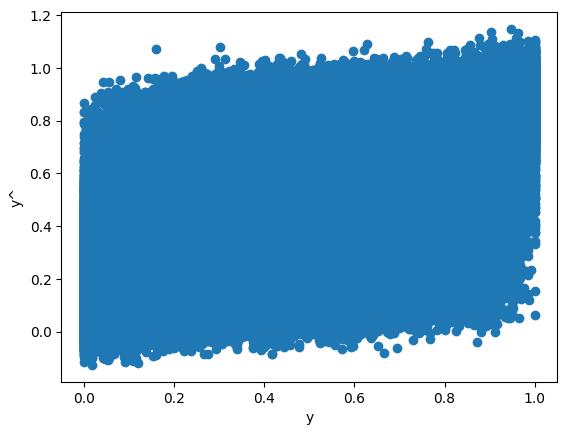


Testing time: 0.013 s
----- EVALUATION ON VAL SET ------
MSE: 0.009226755753166152
RMSE 0.096056003212533
MAE: 0.06501791041888691
R^2:  0.8580128237995428



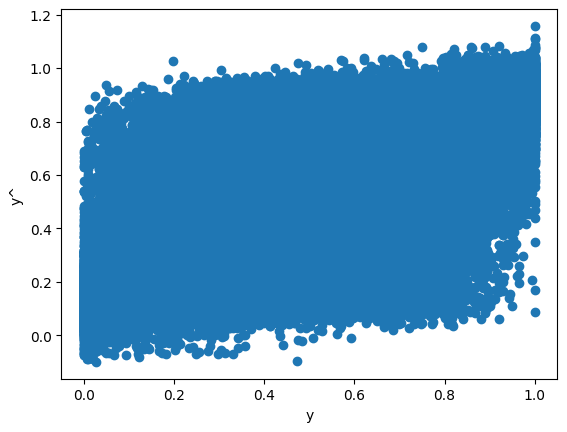

y_hat_t    [0.5937579743855661, 0.5959482602115472, 0.596...
mse_t                                               0.012619
rmse_t                                              0.112336
mae_t                                               0.074931
r2_t                                                0.815106
y_hat_v    [0.8111829663647226, 0.7306312350562083, 0.843...
mse_v                                               0.009227
rmse_v                                              0.096056
mae_v                                               0.065018
r2_v                                                0.858013
dtype: object

In [22]:
ridge_reg.fit(x_train_prepared,y_train)
test_model(ridge_reg, x_train_prepared, y_train, x_test_prepared, y_test)

In [23]:
%%time 

lasso_reg = linear_model.Lasso(alpha=0.01) # Create a Ridge regressor
cross_val_evaluation(lasso_reg,x_train_prepared, y_train,'Lasso Regression')
#   Lasso Regression
# Scores: [0.85542452 0.844529   0.82666133 0.81003802 0.80356838]
# Mean: 0.8280442480533837
# Standard deviation: 0.0197313499648892
# CPU times: user 2min 14s, sys: 3min 2s, total: 5min 16s
# Wall time: 1min 28s


  Lasso Regression
Scores: [0.8010582  0.80428885 0.80047365 0.80198791 0.80376526]
Mean: 0.8023147716541041
Standard deviation: 0.0014883832245621788
CPU times: user 21.4 s, sys: 9.46 s, total: 30.9 s
Wall time: 17.8 s



Training time: 0.079 s
----- EVALUATION ON VAL SET ------
MSE: 0.013491743854929374
RMSE 0.11615396616099415
MAE: 0.07948860953560868
R^2:  0.8023247518059745



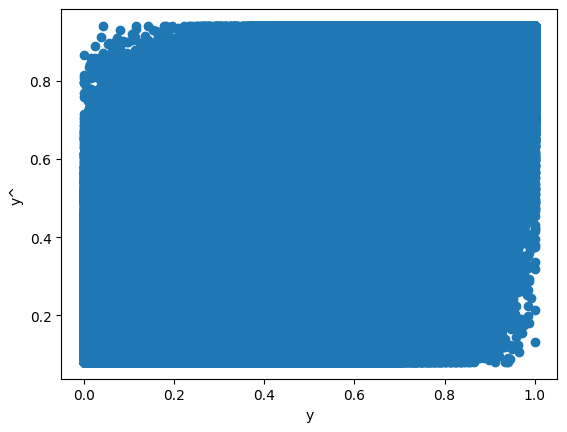


Testing time: 0.02 s
----- EVALUATION ON VAL SET ------
MSE: 0.009761561849165185
RMSE 0.09880061664364846
MAE: 0.06664879783266855
R^2:  0.8497828880109384



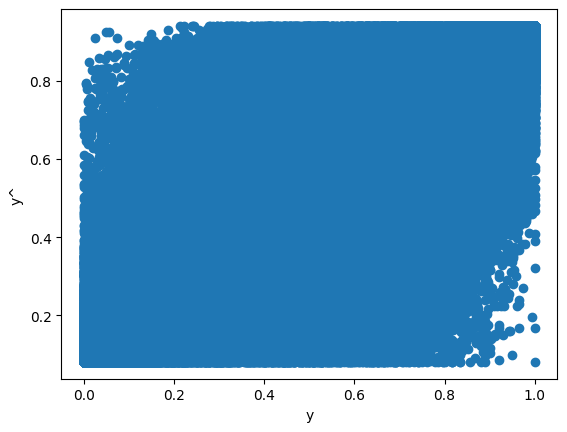

y_hat_t    [0.5850866615437204, 0.5850866615437204, 0.585...
mse_t                                               0.013492
rmse_t                                              0.116154
mae_t                                               0.079489
r2_t                                                0.802325
y_hat_v    [0.8169640794288758, 0.7352295106724226, 0.837...
mse_v                                               0.009762
rmse_v                                              0.098801
mae_v                                               0.066649
r2_v                                                0.849783
dtype: object

In [24]:
lasso_reg.fit(x_train_prepared,y_train)
test_model(lasso_reg, x_train_prepared, y_train, x_test_prepared, y_test)

## KNN3

## SVM 

## Random forest

## Gradiend Boosting

## Generate Sample

In [52]:
sample_data = pd.read_csv('dades/metadata_sample_submission.csv/metadata_sample_submission.csv')

In [53]:
sample_data

,index,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074
1,1,337,3,23,12,0.463768,0.536232,0.532609,0.601449
2,2,368,3,31,1,0.787037,0.709877,0.611111,0.601852
3,3,327,3,23,15,0.753472,0.809028,0.819444,0.736111
4,4,328,3,4,20,0.861111,0.802469,0.814815,0.827160
...,...,...,...,...,...,...,...,...,...
54994,54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261
54995,54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160
54996,54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778
54997,54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222


In [54]:
sample_data['year'] = 2023

In [55]:
sample_data['datetime'] = pd.to_datetime(sample_data[['year','month','day']])
sample_data['dayofweek'] = sample_data.datetime.dt.dayofweek


In [56]:
sample_data

,index,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,year,datetime,dayofweek
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,2023-03-07,1
1,1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,2023-03-23,3
2,2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,2023-03-31,4
3,3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,2023-03-23,3
4,4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,2023-03-04,5
...,...,...,...,...,...,...,...,...,...,...,...,...
54994,54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,2023-03-14,1
54995,54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2023-03-01,2
54996,54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,2023-03-20,0
54997,54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,2023-03-14,1


In [57]:
sample_data.drop(['datetime', 'index'], axis=1, inplace=True)

In [62]:
sample_data.rename(
    columns = {
        'ctx-4':'ctx4',
        'ctx-3':'ctx3',
        'ctx-2':'ctx2',
        'ctx-1':'ctx1'
    },
    inplace=True
)

In [63]:
sample_data

,station_id,month,day,hour,ctx4,ctx3,ctx2,ctx1,year,dayofweek
0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1
1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3
2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4
3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3
4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5
...,...,...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1
54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2
54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,0
54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,1


In [65]:
x_val = x_test
y_val = y_test


In [68]:
# (config, x_train,x_val,y_train,y_val)
show = True
full_pipeline = build_preprocessor(config)

x_train_prepared = full_pipeline.fit_transform(x_train)
x_val_prepared = full_pipeline.transform(x_val)
x_test_prepared = full_pipeline.transform(sample_data)

if show:
    print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
    print("x_test_prepared:",x_val_prepared.shape,"y_test: ",y_val.shape)
    print("x_test_prepared:",x_test_prepared.shape)


x_train_prepared: (3541851, 417) y_train:  (3541851,)
x_test_prepared: (882910, 417) y_test:  (882910,)
x_test_prepared: (54999, 417)


In [69]:
%%time 

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,x_train_prepared, y_train,'Linear Regression')



  Linear Regression
Scores: [0.81364582 0.81717717 0.81316458 0.81492124 0.81631799]
Mean: 0.8150453587706241
Standard deviation: 0.0015281128416396233
CPU times: user 43.4 s, sys: 2min 29s, total: 3min 12s
Wall time: 15.3 s



Training time: 0.056 s
----- EVALUATION ON VAL SET ------
MSE: 0.012619347920367263
RMSE 0.11233587103132847
MAE: 0.07493170810584807
R^2:  0.8151067231168971



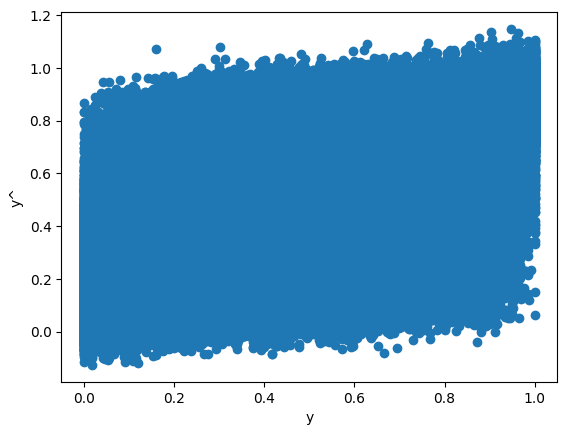


Testing time: 0.014 s
----- EVALUATION ON VAL SET ------
MSE: 0.009226668278492455
RMSE 0.09605554787982033
MAE: 0.06501703857053986
R^2:  0.858014169915365



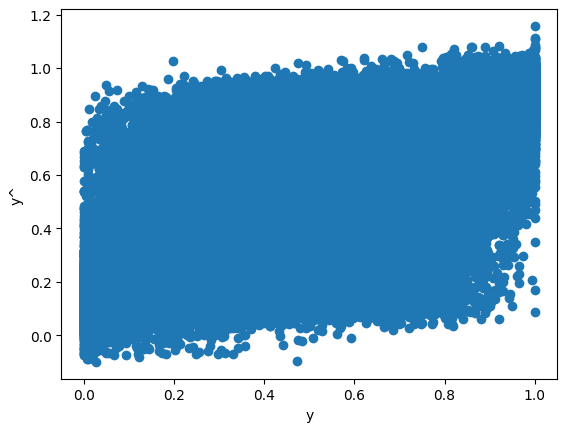

y_hat_t    [0.5937903655761995, 0.5959809142176841, 0.596...
mse_t                                               0.012619
rmse_t                                              0.112336
mae_t                                               0.074932
r2_t                                                0.815107
y_hat_v    [0.8111725373542672, 0.7306215344153076, 0.843...
mse_v                                               0.009227
rmse_v                                              0.096056
mae_v                                               0.065017
r2_v                                                0.858014
dtype: object

In [70]:
lin_reg.fit(x_train_prepared,y_train)
test_model(lin_reg, x_train_prepared, y_train, x_val_prepared, y_val)

In [71]:
yhat = lin_reg.predict(x_test_prepared)


In [73]:
yhat.shape

(54999,)

In [76]:
sample_data['percentage_docks_available'] = yhat

In [94]:
sample_data['percentage_docks_available'].to_csv('predicton_lr.csv', header=True)